## Exercise 1: K-means Clustering
*Implement the K-means clustering algorithm and apply it to compress an image*

In [1]:
from numpy import *
%pylab inline
import scipy.optimize as op
import pandas as pd
import os
import scipy.io as sio
from sklearn import svm

Populating the interactive namespace from numpy and matplotlib


*Write k-means algorithm to automatically cluster similar data examples together. 
Read 2D point data to test the algorithm.*

In [2]:
raw_data = sio.loadmat("ex7data2.mat")

In [3]:
X = raw_data["X"]

In [4]:
X.shape

(300L, 2L)

*Chose initial centroids from original data*

In [5]:
K = 3 # 3 centroids
initial_centroids = array([[3, 3], [6, 2], [8, 5]])

*Code to find the closest centroid for each example.*

In [6]:
def findClosestCentroids(X, initial_centroids):
    num_centroids = initial_centroids.shape[0]
    d = zeros((X.shape[0],num_centroids))
    for ii in range(num_centroids):
        centroid = initial_centroids[ii,:]
        d[:,ii] = sum((X-centroid)**2,axis = 1)
    id_x = argmin(d, axis = 1)
    return id_x

In [7]:
id_x = findClosestCentroids(X, initial_centroids)

*Compute new centroid location based on the examples classified as closest to current centroid.*

In [8]:
def computeCentroids(X, idx, K):
    centroids = zeros((K,X.shape[1]))
    count = zeros((K,1))
    m = X.shape[0]
    for ii in range(m):
        id = idx[ii]
        centroids[id,:] += X[ii,:]
        count[id] += 1
    centroids = centroids/count
    return centroids

In [9]:
centroids = computeCentroids(X, id_x, 3)

In [10]:
centroids

array([[ 2.42830111,  3.15792418],
       [ 5.81350331,  2.63365645],
       [ 7.11938687,  3.6166844 ]])

*K-means iterates find nearest centroid and compute centroid steps and returns the final classifications.*

In [11]:
def runkMeans(X, centroids, max_iters):
    # make an array for storing each iteration of the means
    k, n = centroids.shape

    means = zeros((k,n,max_iters+1))
    means[:,:,0] = centroids
    
    for ii in range(max_iters):
        # assign each data point to one of the k-means
        idx = findClosestCentroids(X, centroids)
        # move the means
        centroids = computeCentroids(X, idx, k)
        # store the new mean position
        means[:,:,ii+1] = centroids
        
    return (idx, centroids, means)

*Run K-means on sample data and plot final classifications, as well as the progress of the means vs. iteration.*

In [12]:
(idx, centroids, means) = runkMeans(X, initial_centroids, 10)

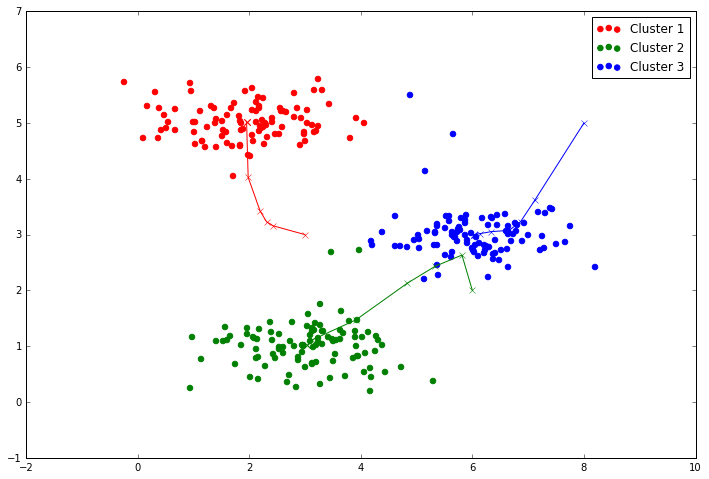

In [13]:
cluster1 = X[where(idx == 0)[0],:]
cluster2 = X[where(idx == 1)[0],:]
cluster3 = X[where(idx == 2)[0],:]

figure(figsize=(12,8))
scatter(cluster1[:,0], cluster1[:,1], s=30, color='r', label='Cluster 1')
scatter(cluster2[:,0], cluster2[:,1], s=30, color='g', label='Cluster 2')
scatter(cluster3[:,0], cluster3[:,1], s=30, color='b', label='Cluster 3')
legend()

plot(means[0,0,:],means[0,1,:],'rx-')
plot(means[1,0,:],means[1,1,:],'gx-')
plot(means[2,0,:],means[2,1,:],'bx-')

*Code for choosing random centroid from sample data.*

In [14]:
def kMeansInitCentroids(X, K):
    m, n = X.shape
    centroids = zeros((K, n))
    idx = random.randint(0, m, K)
    
    for i in range(K):
        centroids[i,:] = X[idx[i],:]
    
    return centroids

In [15]:
initial_centroids = kMeansInitCentroids(X, 3)
initial_centroids

array([[ 2.54071672,  0.98392516],
       [ 2.61207029,  0.99076856],
       [ 1.8929766 ,  4.89043209]])

*Same as above, but without storing intermediate values of the means.*

In [16]:
def runkMeans(X, centroids, max_iters):
    k, n = centroids.shape
    
    for ii in range(max_iters):
        # assign each data point to one of the k-means
        idx = findClosestCentroids(X, centroids)
        # move the means
        centroids = computeCentroids(X, idx, k)

    return (idx, centroids)

*Check the effect of starting with different initial values of the centroids.*

In [17]:
# try out a 
for trial in range(10):
    initial_centroids = kMeansInitCentroids(X, 3)
    (idx, centroids) = runkMeans(X, initial_centroids, 25)
    print centroids

[[ 6.03366736  3.00052511]
 [ 1.95399466  5.02557006]
 [ 3.04367119  1.01541041]]
[[ 6.03366736  3.00052511]
 [ 1.95399466  5.02557006]
 [ 3.04367119  1.01541041]]
[[ 1.95399466  5.02557006]
 [ 6.03366736  3.00052511]
 [ 3.04367119  1.01541041]]
[[ 1.95399466  5.02557006]
 [ 6.03366736  3.00052511]
 [ 3.04367119  1.01541041]]
[[ 3.04367119  1.01541041]
 [ 6.03366736  3.00052511]
 [ 1.95399466  5.02557006]]
[[ 3.04367119  1.01541041]
 [ 6.03366736  3.00052511]
 [ 1.95399466  5.02557006]]
[[ 3.04367119  1.01541041]
 [ 1.95399466  5.02557006]
 [ 6.03366736  3.00052511]]
[[ 3.04367119  1.01541041]
 [ 1.95399466  5.02557006]
 [ 6.03366736  3.00052511]]
[[ 3.04367119  1.01541041]
 [ 6.03366736  3.00052511]
 [ 1.95399466  5.02557006]]
[[ 3.04367119  1.01541041]
 [ 6.03366736  3.00052511]
 [ 1.95399466  5.02557006]]


### Next, compress an image using k-means

*Our image contains thousands of colors, and in this part of the exercise, you will reduce the number of colors to 16 colors.* 

*Read in image of a bird.*

In [18]:
data = imread('bird_small.png')
data.shape

(128L, 128L, 3L)

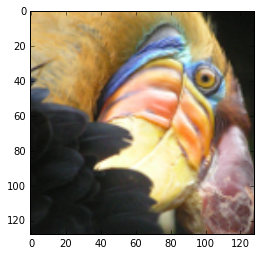

In [19]:
imshow(data)

*Reshape image so that the pixels are all in 1D, and the R, G, and B values of the pixels are the other dimension.*

In [20]:
A = reshape(data,(128*128,3))/255
A.shape

(16384L, 3L)

*Compress original 8 bit image to only 16 colors by clustering using 16 means.*

In [21]:
K = 16 # compress to 16 colors (means)
max_iters = 10

In [22]:
initial_centroids = kMeansInitCentroids(A, K)
initial_centroids

array([[ 0.00204537,  0.00150711,  0.00064591],
       [ 0.00121492,  0.00139946,  0.0014456 ],
       [ 0.00215302,  0.00175317,  0.00090734],
       [ 0.00330642,  0.0028912 ,  0.00198385],
       [ 0.00369089,  0.00336794,  0.00210688],
       [ 0.00387543,  0.00312188,  0.00212226],
       [ 0.00386005,  0.0033218 ,  0.00196847],
       [ 0.00039985,  0.00041522,  0.00032295],
       [ 0.00389081,  0.00387543,  0.00315263],
       [ 0.00261438,  0.00230681,  0.00233756],
       [ 0.00373702,  0.00207612,  0.00130719],
       [ 0.00324491,  0.00272203,  0.00247597],
       [ 0.00073818,  0.00076894,  0.00078431],
       [ 0.00295271,  0.00218378,  0.00215302],
       [ 0.00324491,  0.00266052,  0.00224529],
       [ 0.00099962,  0.00066128,  0.00055363]])

*Cluster the color data.*

In [23]:
idx, centroids = runkMeans(A, initial_centroids, max_iters)
centroids.shape, idx.shape

((16L, 3L), (16384L,))

*Change 8bit color into the closest of the 16 mean colors.*

In [24]:
A_recovered = centroids[idx,:]

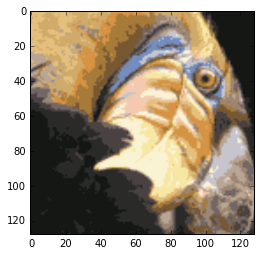

In [25]:
imshow(reshape(A_recovered,(128,128,3))*255)

## Exercise 2: Principal component analysis
*Use principal component analysis (PCA) to perform dimensionality reduction. First experiment with an example 2D dataset to get intuition on how PCA works, and then use it on a bigger dataset of 5000 face image dataset.*

*First, load 2D sample data to test the algorith.*

In [26]:
raw_data = sio.loadmat("ex7data1.mat")

In [27]:
X = raw_data["X"]
X.shape

(50L, 2L)

*Plot data. Looks like data scatters around a line.*

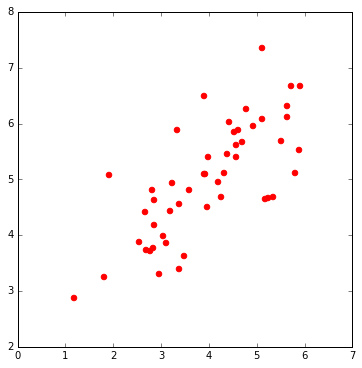

In [28]:
figure(figsize=(6,6))
scatter(X[:,0], X[:,1], s=30, color='r')

*Do feature normalization, define PCA function.*

In [29]:
def featureNormalize(X):
    mu = mean(X,axis=0)
    sigma = std(X,axis=0)
    X_norm = (X-mu)/sigma
    return X_norm, mu, sigma

In [30]:
def pca(X):
    m = X.shape[0]
    
    # find covariance matrix
    C = dot(Xn.T,Xn)/m
    
    # perform singular value decomposition
    U, S, V = svd(C)
    
    return U, S

*Apply PCA to data. Plot principal components on the data.*

In [31]:
Xn, mu, sigma = featureNormalize(X)

In [32]:
U, S = pca(Xn)
U, S

(array([[-0.70710678, -0.70710678],
        [-0.70710678,  0.70710678]]), array([ 1.73553038,  0.26446962]))

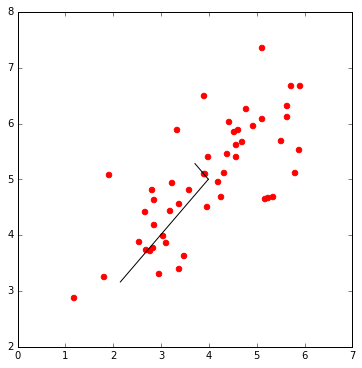

In [33]:
x1 = mu[0]+[0,U[0,0]*S[0]*1.5] 
y1 = mu[1]+[0,U[1,0]*S[0]*1.5]

x2 = mu[0]+[0,U[0,1]*S[1]*1.5]
y2 = mu[1]+[0,U[1,1]*S[1]*1.5]

figure(figsize=(6,6))
scatter(X[:,0], X[:,1], s=30, color='r')
plot(x1,y1,'k')
plot(x2,y2,'k')

*Project each example onto a lower dimensional space (onto the largest eigenvector from PCA) to reduce the dimensionality of the data while retaining most of the variation.*

In [34]:
def projectData(X, U, K):
    U_reduce = U[:,:K]
    Z = dot(X,U_reduce)
    return Z

In [35]:
Z = projectData(Xn, U, 1)
Z[0]

array([ 1.49631261])

*Recover the 2D data from the 1D projection and plot.*

In [36]:
def recoverData(Z, U, K):
    # multiply Z by the first K vectors
    U_reduce = U[:,:K]
    X_rec = dot(Z,U_reduce.T)
    return X_rec

In [37]:
X_rec = recoverData(Z,U,1)*sigma+mu

In [38]:
X[0],X_rec[0]

(array([ 3.38156267,  3.38911268]), array([ 2.76059072,  3.93086928]))

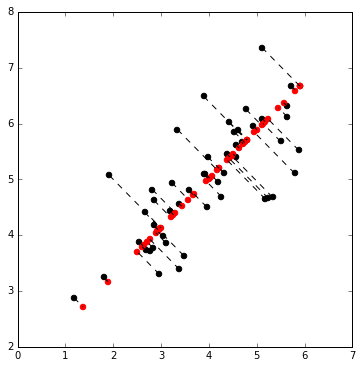

In [39]:
figure(figsize = (6,6))

scatter(X[:,0],X[:,1],s=30, color='k')
scatter(X_rec[:,0],X_rec[:,1],s=30, color='r')

for ii in range(X.shape[0]):
    plot([X[ii,0],X_rec[ii,0]],[X[ii,1],X_rec[ii,1]],'k--')

## Compress faces

*Load face images and visualize a subset.*

In [40]:
raw_data = sio.loadmat("ex7faces.mat")

In [41]:
face_data = raw_data["X"]
face_data.shape

(5000L, 1024L)

In [42]:
def DisplayData(data):
    m = data.shape[0]
    n = data.shape[1]
    cols = int(sqrt(m))
    rows = cols
    imsize = int(sqrt(n))

    fig = figure(figsize(10,10))

    for ix in range(rows):
        for iy in range(cols):
            index = iy*rows+ix
            im = reshape(data[index,:],(imsize,imsize))
            subplot(rows,cols,index+1)
            plt = imshow(im.T)
            plt.set_cmap('gray')
            plt.axes.xaxis.set_ticks([])
            plt.axes.yaxis.set_ticks([])

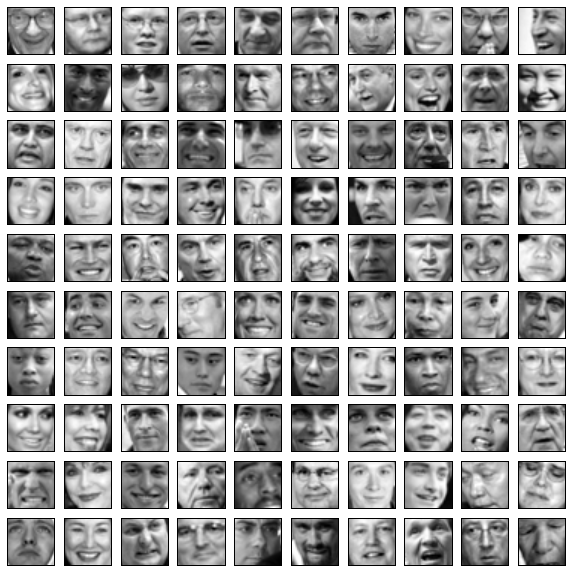

In [43]:
DisplayData(face_data[:100,:])

*Do PCA analysis on image pixels*

In [44]:
Xn, mu, sigma = featureNormalize(face_data)

In [45]:
U, S = pca(Xn)

In [46]:
U.shape

(1024L, 1024L)

*Visualize top eigenvectors.*

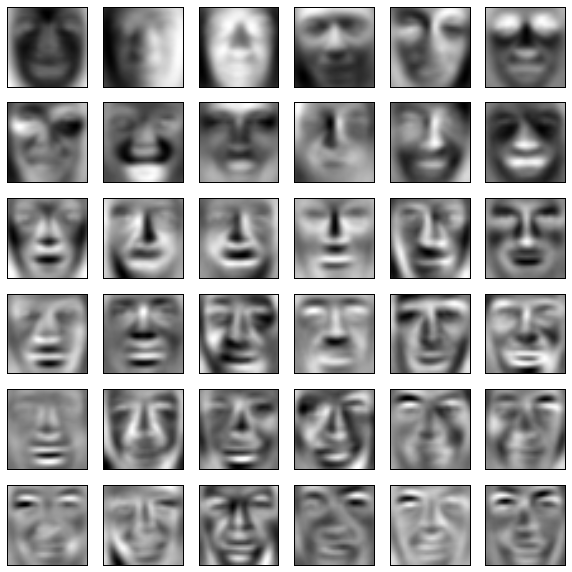

In [47]:
DisplayData(U[:,:36].T)

*Do dimensionality reduction of face images, visualize.*

In [48]:
Z = projectData(Xn, U, 100)
X_rec = recoverData(Z,U,100)*sigma+mu

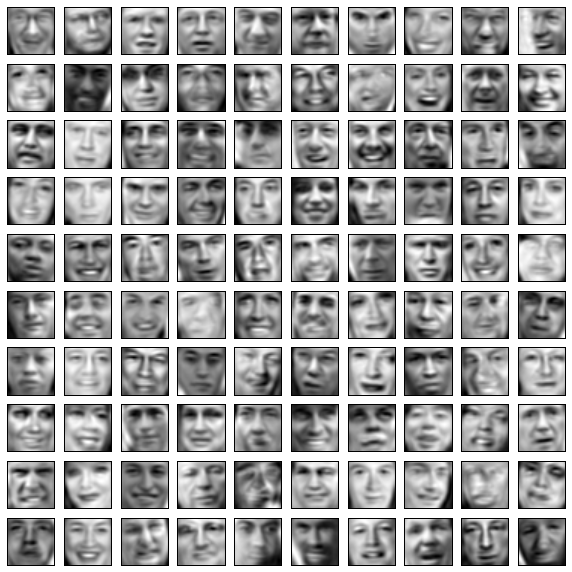

In [49]:
DisplayData(X_rec[:100,:])